# Capstone - EDA with Kaggle Dataset

This image classification problem follows all with this [kaggle competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) from 2017.

In [114]:
import sys
import os
import time


import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import matplotlib.pyplot as plt
import shutil

from spectral import *
from skimage import io
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore')

## Setup
Set `PLANET_KAGGLE_ROOT` to the directory where you've downloaded the TIFF and JPEG zip files, and accompanying CSVs.

In [46]:
PLANET_KAGGLE_TRAIN_ROOT = os.path.abspath("./train_data/")
PLANET_KAGGLE_TEST_ROOT = os.path.abspath("./test_data/")
PLANET_KAGGLE_LABEL_CSV = os.path.join("./kaggle_csv_files/train_v2.csv")
assert os.path.exists(PLANET_KAGGLE_TRAIN_ROOT)
assert os.path.exists(PLANET_KAGGLE_TEST_ROOT)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

## Inspect image labels
Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [47]:
target = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
target.columns = ["image_name", "labels"]
target.head()

,image_name,labels
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [48]:
# Build list with unique labels
label_list = []
for tag_str in target['labels'].values:
    label_tags = tag_str.split(' ')
    for label in label_tags:
        if label not in label_list:
            label_list.append(label)

In [49]:
# Add onehot features for every label
for label in label_list:
    target[label] = target['labels'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
target.head()

,image_name,labels,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [50]:
target['labels'].value_counts().head()

clear primary                     13636
partly_cloudy primary              3630
cloudy                             2089
clear primary water                1850
agriculture clear primary road     1680
Name: labels, dtype: int64

In [51]:
target.to_csv("./converted_data_files/files_and_labels_dataframe.csv", index=False)

In [52]:
target[label_list].sum().sort_values(ascending = False)

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4477
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
conventional_mine      100
blow_down               98
dtype: int64

Now, let's look at the labels' frequencies, and which ones cooccur. You'll notice that the classes are very uneven, e.g. the weather related tags are much more frequent than the land use tags, e.g. selective_logging)

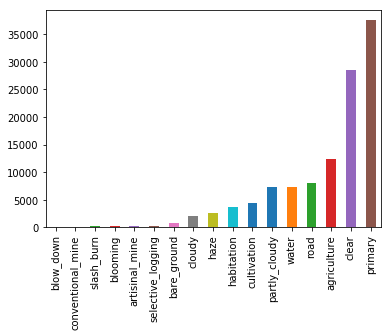

In [53]:
# Histogram of label instances
target[label_list].sum().sort_values().plot.bar();

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


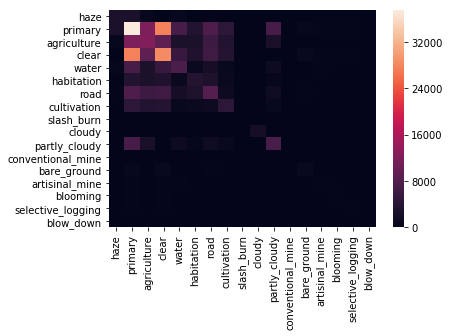

In [54]:
def make_cooccurence_matrix(label_category):
    numeric_df = target[label_category]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


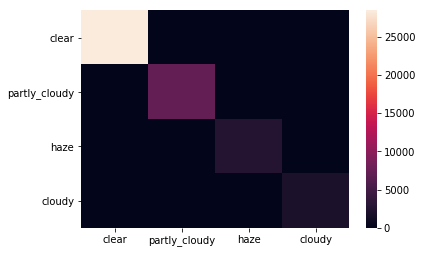

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


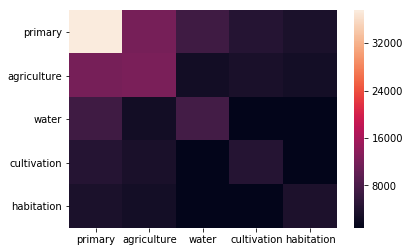

In [13]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rarer labels have very little overlap:

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


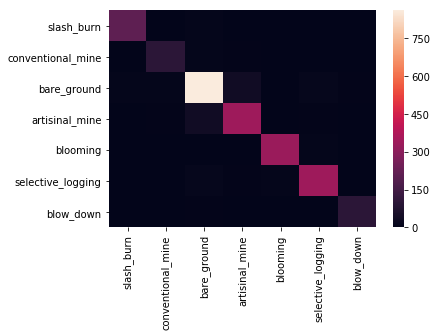

In [14]:
rare_labels = [l for l in label_list if target[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

# Plotting the Tiff's.

In [73]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True

    for tag in tags:
        condition = condition & target[tag] == 1
    if n is not None:
        return target[condition].sample(n)
    else:
        return target[condition]

In [74]:
def load_image(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join(PLANET_KAGGLE_TRAIN_ROOT, filename + ".tif"))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])

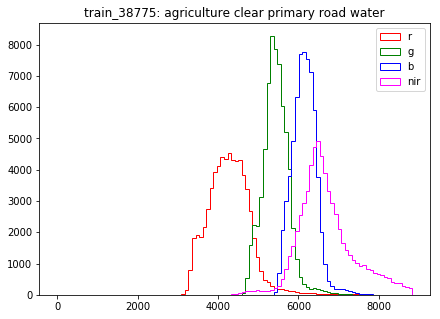

In [102]:
image_path = sample_images(['primary', 'water', 'road'], n=1)['image_name'].iloc[0]
rgbn_image = load_image(image_path)
rgb_image = rgbn_image[:,:,:3]
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]

plt.figure(figsize = (7,5))
plt.title(label = "{}: {}".format(image_path, target.iloc[int(image_path.lstrip("train_"))]['labels']))
for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
    plt.hist(slice_.ravel(), bins=100, 
             range=[0,rgb_image.max()], 
             label=name, color=color, histtype='step', )
plt.legend();

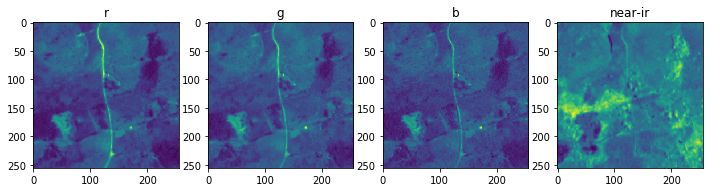

In [103]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

# Making Tif images more readable

In [107]:
path = os.path.join(PLANET_KAGGLE_TRAIN_ROOT, image_path + '.tif')
img = io.imread(path)
bgr_image = img[:,:,:3]
rgb = bgr_image[:, :, [2,1,0]]

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [3118.0, 7958.0]
    G: [4530.0, 7991.0]
    B: [5325.0, 8829.0]

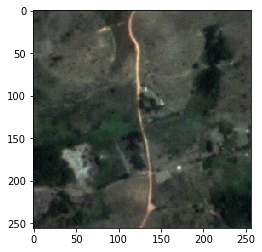

In [108]:
imshow(rgb)

## Bulk Converting Images to Raster with the rasterio library
_A Raster is, basically, a numpy array that preserves geolocation data._

The files can be easily read into numpy arrays with the [rasterio](https://mapbox.github.io/rasterio/) library. The code below assumes you've extracted the zip files into the directories specified above.



In [12]:
# This function loops through any folder organized with geo_tif files and coverts them to raster. 
# New rasters are arrays and are appended to a list, which is then converted back to numpy array.
# Currently, this method does not preserve the geolocation data associated with rasters. 
# Geolocation information was not needed for this project.
# Suggested mute warnings associate with loss of geodata when running a big loop function like this...

def convert_to_raster(file_path = PLANET_KAGGLE_TRAIN_ROOT, 
                      file_root = '/train_'):
    print_counter = 0
    raster_list = []
    for file in range((len(os.listdir(file_path)) + 1)):
        path = (file_path + file_root + str(file) + '.tif')
        print_counter += 1

        if os.path.exists(path):
            with rasterio.open(path) as src:
                b, g, r, nir = src.read()
                raster = np.dstack([r, g, b, nir])
                raster_list.append(raster)
        
        if file % 1000 == 0:
            print('Current file: {}'.format(path))
            print("{} files have been converted to raster...".format(print_counter))
            print('')
                      
    return np.array(raster_list)

In [ ]:
# Converting the training images to arrays.
training_data = convert_to_raster(PLANET_KAGGLE_TRAIN_ROOT)
print("The training data has {} values, each with input shape of {}.".format(training_data.shape[0], training_data.shape[1:]))

In [ ]:
training_data.shape

## Converting the train data to arraysand saving to .npy file

In [ ]:
# Save the training data - Converted. Cool.
np.save('./kaggle_datasets/training_data.npy', arr = training_data)

# Renaming the mislabeled files

In [22]:
# the test files should match the order of the submission data format.
# files with the "test_" prefix, first
submit_id = pd.read_csv('./kaggle_datasets/sample_submission_v2.csv')
submit_id.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [23]:
# followed by files with the new "file_prefix"
# The "file_" files are sorted by numeric character, so they aren't exactly ascending.
# This sorting order is forced by the Apple computer finder
submit_id.tail()

,image_name,tags
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water
61190,file_9999,primary clear agriculture road water


In [25]:
# based on the mapping file, only the "file_" test data is incorrectly named. 
new_test_labels = pd.read_csv('./kaggle_datasets/test_v2_file_mapping.csv')
new_test_labels.head()

,old,new
0,file_4158.tif,file_18830.tif
1,file_1668.tif,file_19164.tif
2,file_2411.tif,file_15749.tif
3,file_16047.tif,file_7531.tif
4,file_1271.tif,file_18347.tif


In [28]:
new_test_labels.tail()

,old,new
20517,file_17774.tif,file_14520.tif
20518,file_3538.tif,file_6633.tif
20519,file_1923.tif,file_4685.tif
20520,file_14047.tif,file_14571.tif
20521,file_8220.tif,file_7483.tif


In [29]:
print(new_test_labels.shape)

(20522, 2)


In [ ]:
BASEPATH = './kaggle_tif_data/' 
WORKING = './kaggle_tif_data/'

TIFPATH = os.path.join(BASEPATH, 'test-tif-v2/')

# I added a new directory for the fixed files
FIXEDPATH = os.path.join(WORKING, 'fixed/')

## This function fixes the mislabeled file names

This is a _safe_ rewrite, so all the new file names are still copies of the original files, saved to a new `./fixed` directory. I then erased all of the original, unlabeled files with the `file_` prefix from the `test-tif-v2/` directory.

In [ ]:
# def copy_and_rename(num_files=new_test_labels.shape[0]):
#     '''Copy up to `num_files` images to the scratch directory.
#     `num_files` is needed because you can only write a few hundred
#     megabytes in this kernel environment. Use the `df -h` command
#     to check.
    
#     This is a purposely non-destructive operation. You'll need to
#     move the renamed files back to the test-tif-v2 directory so
#     that your existing scripts will continue to work.
#     '''
#     n = 0

#     if not os.path.exists(FIXEDPATH):
#         os.mkdir(FIXEDPATH)

#     for index, row in new_test_labels.iterrows():
#         old = os.path.join(TIFPATH, row['old'])
#         new = os.path.join(FIXEDPATH, row['new'])
#         shutil.copy(old, new)
#         n += 1
#         if n % 1000 == 0:
#             print('Copied {}'.format(n))
            

# copy_and_rename()
        

## Converting the Test Data

This function is convenient if working in a high processing environment. However, after running into memory challenges, I used the `ImageDataGenerator` from `keras_preprocessing` - which allows reduced memory load via batch processing.

After correcting the incorrectly labeled files, I have to ammend the `conver_to_raster` function from above to pull the test files from the two folders, and account for two file roots (`test_` and `file_`).

In [30]:
PLANET_KAGGLE_FIXED = os.path.abspath("./kaggle_datasets/fixed/")
assert os.path.exists(PLANET_KAGGLE_FIXED)

In [31]:
# I ran this function in the terminal. It converts over 30 GB of data. 
# The RAM loading often killed the jupyter kernal, but could complete via command line script.
# See test_data_conversion.py


def test_convert_to_raster(file_paths = [PLANET_KAGGLE_TEST_ROOT, PLANET_KAGGLE_FIXED],
                           file_roots = ['/test_', '/file_']):

    raster_list = []
    print_counter = 0
    for i in range(2):
        print("Converting files from folder: {}".format(file_paths[i]))
        print(len(os.listdir(file_paths[i])) + 1)
        for id_number in range(len(os.listdir(file_paths[i])) + 1):
            path = (file_paths[i] + file_roots[i] + str(id_number) + '.tif')
            print_counter += 1

            if os.path.exists(path):
                with rasterio.open(path) as src:
                    b, g, r, nir = src.read()
                    raster = np.dstack([r, g, b, nir])
                    raster_list.append(raster)
            else:
                print("Incorrect file path: Please troubleshoot.")
                break

            if id_number % 2500 == 0:
                print('Current file: {}'.format(path))
                print("""{} files have been 
                      converted to raster...\n""".format(print_counter))

    return np.array(raster_list)

In [ ]:
print("The test data has {} rows.".format(test_data.shape[0])

In [ ]:
test_data = test_convert_to_raster()

## Writing the testing data to numpy files. I will load these in the next notebook. 

In [ ]:
np.save('./converted_data_files/test_data.npy', arr = test_data)